# Qiskit circuits backend

> [Qiskit](https://github.com/Qiskit/qiskit) based quantum circuit backend.

In [ ]:
#| default_exp platform.backends.circuits_qiskit

In [ ]:
#| export
from genQC.imports import *
from genQC.platform.backends.base_backend import BaseBackend
from genQC.platform.circuits_instructions import CircuitInstructions
from genQC.platform.tokenizer.base_tokenizer import Vocabulary
from genQC.utils.config_loader import get_obj_from_str

import qiskit.circuit.library as ql
import qiskit.quantum_info as qi

from qiskit import QuantumCircuit, transpile
from qiskit.circuit.gate import Gate

## Utils

In [ ]:
#| export
def get_number_of_gate_params(gate_cls: type[Gate]) -> int:
    # python: gives you the number of any arguments BEFORE *args, minus the ones that have a default, -1 for self parameter of classes
    return gate_cls.__init__.__code__.co_argcount - len(gate_cls.__init__.__defaults__) - 1

In [ ]:
assert get_number_of_gate_params(ql.HGate)  == 0
assert get_number_of_gate_params(ql.CXGate) == 0
assert get_number_of_gate_params(ql.U1Gate) == 1
assert get_number_of_gate_params(ql.U2Gate) == 2
assert get_number_of_gate_params(ql.U3Gate) == 3

In [ ]:
#| export
def instruction_name_to_qiskit_gate(name: str) -> Gate:
    match name:
        case "swap": name = "Swap"
        case "cp":   name = "CPhase"
        case _:      name = name.upper()
        
    return get_obj_from_str(f"qiskit.circuit.library.standard_gates.{name}Gate")

In [ ]:
#| export
def get_target_control_qubits(qc: QuantumCircuit, gate: Gate) -> Tuple[List[int], List[int]]:
    """Get the target and control qubits of a Qiskit `Gate` of a `QuantumCircuit`."""
    
    acts_on_cnt = gate.operation.num_qubits
    acts_on     = [qc.find_bit(qubit).index for qubit in gate.qubits]      # order: (*control_qubits, *target_qubits)

    assert acts_on_cnt == len(acts_on), "error in: acts_on_cnt == len(acts_on)"

    num_ctrl_qubits = gate.operation.num_ctrl_qubits if hasattr(gate.operation, "num_ctrl_qubits") else 0 
    num_targ_qubits = acts_on_cnt - num_ctrl_qubits

    control_qubits, target_qubits = acts_on[:-num_targ_qubits], acts_on[-num_targ_qubits:]   
    return control_qubits, target_qubits  

## Backend

In [ ]:
#| export
class CircuitsQiskitBackend(BaseBackend):

    BASIC_BACKEND_TYPE = type[QuantumCircuit]
    
    def backend_to_genqc(self, qc: QuantumCircuit, ignore_barriers: bool = True) -> CircuitInstructions:
        """Convert a given Qiskit `QuantumCircuit` to genQC `CircuitInstructions`."""

        if ignore_barriers:
            gates = []
            for gate in qc.data:
                if gate.operation.name != "barrier": 
                    gates.append(gate)
        else:
            gates = qc.data
        
        instructions = CircuitInstructions(tensor_shape=torch.Size([qc.num_qubits, len(gates)]))
        
        for gate in gates:          
            control_qubits, target_qubits = get_target_control_qubits(qc, gate)      

            #Correction to qiskit v1.3.1
            #`cp` is symmetric but qiskit uses
            #`cp(theta, control_qubit, target_qubit)` target and control
            #We make it only target connections like `swap` gates
            if gate.operation.name == "cp":
                target_qubits.extend(control_qubits)
                control_qubits = []
            
            instructions.add_instruction(gate.operation.name, control_qubits, target_qubits, gate.operation.params)

        return instructions

    def genqc_to_backend(self, 
                         instructions: CircuitInstructions, 
                         place_barriers: bool = True,
                         ignore_errors: bool = False,
                         place_error_placeholders: bool = False) -> QuantumCircuit:  
        """Convert given genQC `CircuitInstructions` to a Qiskit `QuantumCircuit`."""
        
        gate_classes = {name:instruction_name_to_qiskit_gate(name) for name in instructions.instruction_names_set}        
        qc           = QuantumCircuit(instructions.num_qubits)  
        
        for instruction in instructions.data:
            gate_cls         = gate_classes[instruction.name]      
            num_of_paramters = get_number_of_gate_params(gate_cls)   

            control_qubits, target_qubits = instruction.control_nodes, instruction.target_nodes
            params                        = instruction.params[:num_of_paramters]
            
            try:
                qc.append(gate_cls(*params), [*control_qubits, *target_qubits], [])        
            except Exception as err:
                if ignore_errors: continue
                elif place_error_placeholders:
                    qc.append(ql.UnitaryGate(np.eye(2**instructions.num_qubits), label="Err"), range(instructions.num_qubits))
                    # qc.append(ql.UnitaryGate(np.eye(2), label="Err"), [0])
                    continue
                raise err
            
            if place_barriers: qc.barrier()
    
        return qc 

    def get_unitary(self, qc: QuantumCircuit, remove_global_phase: bool = True) -> np.ndarray:
        """Return the unitary matrix of a `QuantumCircuit`."""
        U = qi.Operator(qc).to_matrix().astype(np.complex128)
        if remove_global_phase:
            U *= np.exp(-1j * qc.global_phase) 
        return U

    def schmidt_rank_vector(self, qc: Optional[QuantumCircuit] = None, densityMatrix: Optional[qi.DensityMatrix] = None) -> List[int]:   
        """Return the SRV of a `qi.DensityMatrix`."""

        if not exists(densityMatrix):
            densityMatrix = qi.DensityMatrix(qc)
        
        systems_cnt = len(densityMatrix.dims())   
        total_trace = set(range(systems_cnt))    
        rank_vector = []
        
        for i in range(systems_cnt): 
            trace = list(total_trace - {i})
            red_densityMatrix = qi.partial_trace(densityMatrix, trace)        
            # r = np.count_nonzero(np.linalg.eigvals(red_densityMatrix) > 1e-14) # was slower during testing   
            r = np.linalg.matrix_rank(red_densityMatrix, hermitian=True).item()       
            rank_vector.append(r)
        
        return rank_vector

    def optimize_circuit(self, 
                         qc: QuantumCircuit, 
                         vocabulary: Vocabulary, 
                         optimization_level: int = 1, 
                         silent: bool = True) -> QuantumCircuit:
        """Use `qiskit.compiler.transpile` to optimize a circuit."""
        
        if optimization_level == 0: 
            return qc
                
        while optimization_level > 0:
            try:
                qc_opt = transpile(qc, optimization_level=optimization_level, basis_gates=vocabulary)
                return qc_opt
                
            except Exception as er: 
                if not silent: print(er)
                pass 
    
            optimization_level -= 1
    
        return qc

    def rnd_circuit(self, 
                    num_of_qubits: int, 
                    num_of_gates:int, 
                    gate_pool: Union[Sequence[Gate], Sequence[str]], 
                    rng: np.random.Generator) -> QuantumCircuit:
        """Create a random `QuantumCircuit`."""

        qc = QuantumCircuit(num_of_qubits)    
        gate_indices = rng.choice(len(gate_pool), num_of_gates)

        gate_pool = list(gate_pool)
        if isinstance(gate_pool[0], str):
            gate_pool = [instruction_name_to_qiskit_gate(gate) for gate in gate_pool]  
        
        for gate_index in gate_indices:
            gate_cls         = gate_pool[gate_index]
            num_of_paramters = get_number_of_gate_params(gate_cls)         
            params           = rng.uniform(low=0, high=4.0*np.pi, size=num_of_paramters) if num_of_paramters > 0 else [] 
            
            gate = gate_cls(*params)      
            act_qubits = rng.choice(num_of_qubits, gate.num_qubits, replace=False)   # order: (*act_qubits)=(*control_qubits, *target_qubits)   
            qc.append(gate, [*act_qubits], [])
        
        return qc

    def randomize_params(self, qc: QuantumCircuit, rng: np.random.Generator) -> QuantumCircuit:
        """Randomize all parameters of a `QuantumCircuit`. This creates a new `QuantumCircuit` and therefore deletes global phase."""
        
        qc_new = QuantumCircuit(qc.num_qubits)
        
        for gate in qc.data:
            gate_cls                       = instruction_name_to_qiskit_gate(gate.operation.name)
            control_qubits, target_qubits  = get_target_control_qubits(qc, gate)
            params                         = rng.uniform(low=0, high=4.0*np.pi, size=len(gate.operation.params))
            
            qc_new.append(gate_cls(*params), [*control_qubits, *target_qubits], [])           
            
        return qc_new

    def draw(self, qc: QuantumCircuit, **kwargs) -> None:
        """Draw the given `QuantumCircuit` using Qiskit.""" 
        return qc.draw("mpl", **kwargs)
        # plt.show()

## Test

In [ ]:
from genQC.platform.tokenizer.circuits_tokenizer import CircuitTokenizer

### genqc <-> backend

In [ ]:
tensor = torch.tensor([
                [3, 0, -2, 0, 0],
                [0, 0,  2, 0, 1],
                [0, 3, -2, 3, 0],
            ], dtype=torch.int32)

params_tensor = torch.tensor([       # ... [max_params, time]
                    [0, 0, 0, 0,  0.9],
                    [0, 0, 0, 0, -0.7]
                ])

vocabulary   = {"u2":1, "ccx":2, "h":3}
tokenizer    = CircuitTokenizer(vocabulary)
instructions = tokenizer.decode(tensor, params_tensor)

instructions.print()

CircuitInstruction(name='h', control_nodes=[], target_nodes=[0], params=[6.2831854820251465, 6.2831854820251465])
CircuitInstruction(name='h', control_nodes=[], target_nodes=[2], params=[6.2831854820251465, 6.2831854820251465])
CircuitInstruction(name='ccx', control_nodes=[0, 2], target_nodes=[1], params=[6.2831854820251465, 6.2831854820251465])
CircuitInstruction(name='h', control_nodes=[], target_nodes=[2], params=[6.2831854820251465, 6.2831854820251465])
CircuitInstruction(name='u2', control_nodes=[], target_nodes=[1], params=[11.9380521774292, 1.8849557638168335])


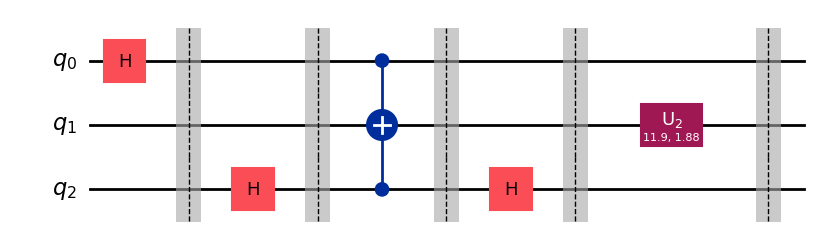

In [ ]:
backend = CircuitsQiskitBackend()

qc = backend.genqc_to_backend(instructions)
qc.draw("mpl")

In [ ]:
dec_instructions = backend.backend_to_genqc(qc)
dec_instructions.print()

CircuitInstruction(name='h', control_nodes=[], target_nodes=[0], params=[])
CircuitInstruction(name='h', control_nodes=[], target_nodes=[2], params=[])
CircuitInstruction(name='ccx', control_nodes=[0, 2], target_nodes=[1], params=[])
CircuitInstruction(name='h', control_nodes=[], target_nodes=[2], params=[])
CircuitInstruction(name='u2', control_nodes=[], target_nodes=[1], params=[11.9380521774292, 1.8849557638168335])


In [ ]:
enc_tensor, enc_params_tensor = tokenizer.encode(dec_instructions)
enc_tensor, enc_params_tensor

(tensor([[ 3,  0, -2,  0,  0],
         [ 0,  0,  2,  0,  1],
         [ 0,  3, -2,  3,  0]], dtype=torch.int32),
 tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.9000],
         [ 0.0000,  0.0000,  0.0000,  0.0000, -0.7000]]))

In [ ]:
assert torch.allclose(tensor, enc_tensor)
assert torch.allclose(params_tensor, enc_params_tensor)

### Calculate unitary and optimize circuit

In [ ]:
gate_pool  = ["u3", "cx",  "h"]
qc         = backend.rnd_circuit(2, 10, gate_pool, np.random.default_rng())
U_initial  = backend.get_unitary(qc)

qc_opt = backend.optimize_circuit(qc, gate_pool, silent=0)
U_opt  = backend.get_unitary(qc_opt, remove_global_phase=False)

print(np.round(U_initial, 2))

assert np.allclose(U_initial, U_opt)

[[ 0.64+0.59j -0.25+0.04j -0.31-0.27j  0.12-0.02j]
 [-0.18-0.18j -0.86+0.11j  0.09+0.08j  0.41-0.06j]
 [-0.11+0.05j -0.11+0.4j  -0.23+0.1j  -0.21+0.84j]
 [ 0.37-0.17j -0.03+0.12j  0.78-0.39j -0.05+0.25j]]


In [ ]:
res = %timeit -o -q backend.get_unitary(qc)
print(f"Timeit get_unitary: {str(res)}")

Timeit get_unitary: 524 μs ± 407 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Initial number of gates 10:


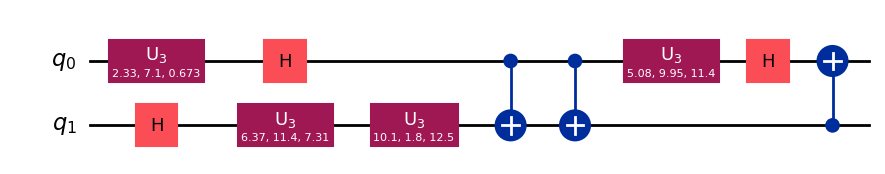

After optimization 3:


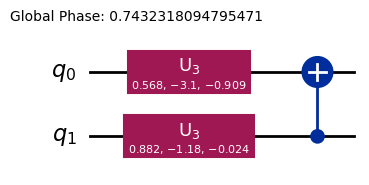

In [ ]:
print(f"Initial number of gates {len(qc.data)}:")
display(qc.draw("mpl"))

print(f"After optimization {len(qc_opt.data)}:")
display(qc_opt.draw("mpl"))

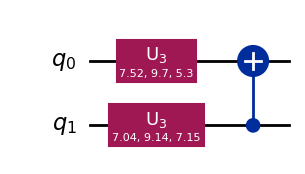

In [ ]:
qc_rand = backend.randomize_params(qc_opt, np.random.default_rng())
display(qc_rand.draw("mpl"))

### Schmidt-rank-vector

In [ ]:
def plot_srv_stat(num_of_qubits, min_gates, max_gates, gate_pool, samples, rng=np.random.default_rng()):    
    srv_list = list()
    for i in range(samples):
        qc  = backend.rnd_circuit(num_of_qubits, rng.integers(min_gates, max_gates+1), gate_pool, rng) 
        qc  = backend.optimize_circuit(qc, gate_pool)
        srv = backend.schmidt_rank_vector(qc)
        srv_list.append(srv)           

    srv_unique, srv_cnt = np.unique(np.array(srv_list), axis=0, return_counts=True)
    srv_unique = [f"{s}" for s in srv_unique]
    
    plt.bar(srv_unique, srv_cnt)
    plt.title("Different SRV distribution")
    plt.show()

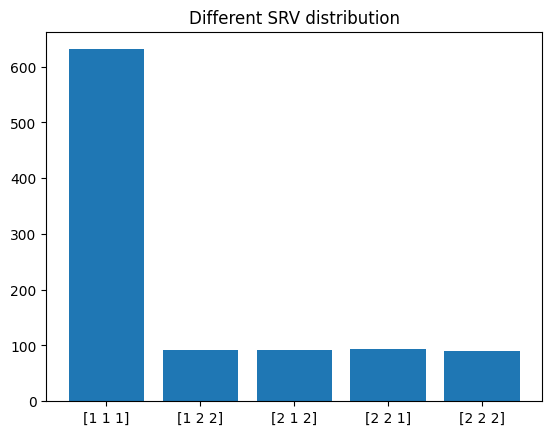

In [ ]:
gate_pool = [ql.HGate, ql.CXGate]

plot_srv_stat(num_of_qubits=3, min_gates=6, max_gates=8, gate_pool=gate_pool, samples=int(1e3), rng=np.random.default_rng())

In [ ]:
def test_srv(system_dims, init, target):
    vec = qi.Statevector(init, dims=system_dims)
    vec *= 1/np.sqrt(vec.trace())
    srv = backend.schmidt_rank_vector(densityMatrix=qi.DensityMatrix(vec)) 
    assert srv == target, f"srv: {srv}"
    print(f"passed test, svr: {srv}")
    display(vec.draw('latex', prefix='|\\psi\\rangle = '))

In [ ]:
#---------------- |0+> = |00>+|01>
system_dims = (2,2)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0] = 1
init[1] = 1
test_srv(system_dims, init, [1, 1])

#----------------Bell, |00>+|11>
system_dims = (2,2)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0] = 1
init[3] = 1
test_srv(system_dims, init, [2, 2])
  
#----------------GHZ, |000>+|111>
system_dims = (2,2,2)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0] = 1
init[7] = 1
test_srv(system_dims, init, [2,2,2])
 
#----------------Sym, |000>+|111>+|222>
system_dims = (3,3,3)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0]  = 1
init[13] = 1
init[26] = 1
test_srv(system_dims, init, [3,3,3])
      
#----------------Wikipedia example, |000>+|101>+|210>+|311>
system_dims = (4,4,4)
init = np.zeros(np.prod(system_dims), dtype=complex)
init[0]  = 1
init[17] = 1
init[36] = 1
init[53] = 1
test_srv(system_dims, init, [2, 2, 4])

passed test, svr: [1, 1]


<IPython.core.display.Latex object>

passed test, svr: [2, 2]


<IPython.core.display.Latex object>

passed test, svr: [2, 2, 2]


<IPython.core.display.Latex object>

passed test, svr: [3, 3, 3]


<IPython.core.display.Latex object>

passed test, svr: [2, 2, 4]


<IPython.core.display.Latex object>

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()